In [3]:
import idx2numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from model_tools import PenalizedRegression as pr
from model_tools import FeatureSelection as fs

import time

from sklearn import datasets
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import pipeline
from sklearn import metrics

## Load MNIST

In [2]:
X_train_loc = "../../data/mnist/train-images-idx3-ubyte/train-images.idx3-ubyte"
y_train_loc = "../../data/mnist/train-labels-idx1-ubyte/train-labels.idx1-ubyte"

X_test_loc = "../../data/mnist/t10k-images-idx3-ubyte/t10k-images.idx3-ubyte"
y_test_loc = "../../data/mnist/t10k-labels-idx1-ubyte/t10k-labels.idx1-ubyte"

In [3]:
X_train = idx2numpy.convert_from_file(X_train_loc)
y_train = idx2numpy.convert_from_file(y_train_loc)

X_test = idx2numpy.convert_from_file(X_test_loc)
y_test = idx2numpy.convert_from_file(y_test_loc)

## Flatten MNIST

In [4]:
def flatten_image(image_array):
    return image_array.reshape(-1, image_array.shape[1]*image_array.shape[2])

## Data Pre-processing

In [5]:
X_train_1d = flatten_image(X_train)
X_test_1d = flatten_image(X_test)

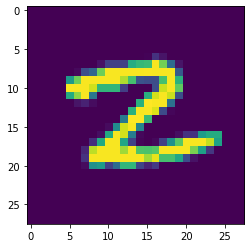

In [6]:
target = 2
y_train = (y_train == target).astype("int")
y_test = (y_test == target).astype("int")
plt.imshow(X_train[np.where(y_train)[0][10],:,:])

In [7]:
scaler = preprocessing.StandardScaler()

## Models
cv=3

In [8]:
scoring = "roc_auc"

np.random.seed(1234)
size = 2000

train_idx = np.random.choice(np.arange(X_train.shape[0]), size=size, replace=False)

time 137.86s
0.9691564412888916 0.9724396908214566


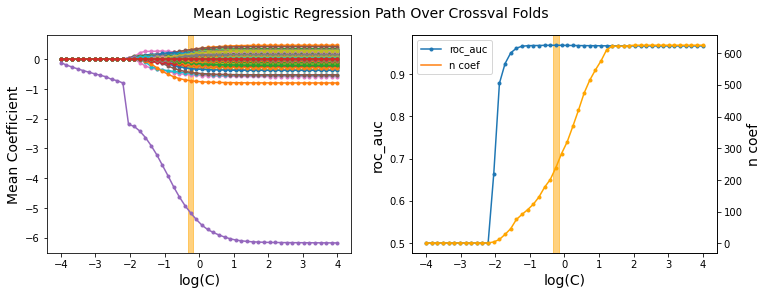

In [9]:
model = linear_model.LogisticRegressionCV(
    cv=2, Cs=50, penalty="l1", scoring=scoring, solver="saga", random_state=42, max_iter=1e4, n_jobs=-1)

pipe = pipeline.Pipeline([('scaler', scaler), ('model', model)])

start = time.time()
pipe.fit(X_train_1d[train_idx,:], y_train[train_idx])
end = time.time()

print("time {0:.2f}s".format(end-start))
print(pipe.score(X_train_1d, y_train), 
      pipe.score(X_test_1d, y_test))

fig, (ax1, ax2) = pr.plot_logistic_cv(pipe["model"], marker='.', figsize=[12,4], fontsize=14)

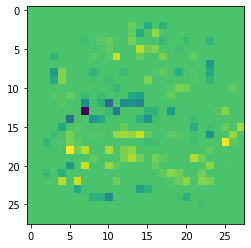

In [10]:
plt.imshow(pipe["model"].coef_.reshape(X_train.shape[1:]))

100%|████████████████████████████████████████████████████████████████████████████████| 784/784 [07:22<00:00,  1.77it/s]


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='Step', ylabel='Mean Validation Accuracy'>)

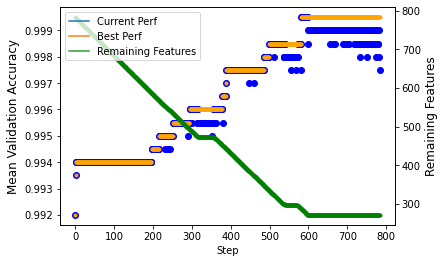

In [20]:
model = linear_model.LogisticRegression(
    penalty='none', random_state=42, solver="saga", max_iter=1e4, warm_start=True, n_jobs=-1)
pipe = pipeline.Pipeline([('scaler', scaler), ('model', model)])

pipe.fit(X_train_1d[train_idx,:], y_train[train_idx])
col_order = np.abs(pipe["model"].coef_[0]).argsort()

res = fs.dropcol_iterate(
    pipe, X_train_1d[train_idx,:], y_train[train_idx], n_splits=2, random_state=42, col_order=col_order, scoring="sketchy")
fs.plot_dropcol(res["summary"])

In [12]:
dropped_idx = list(res["summary"]["col_idx"][res["summary"]["is_dropped"]])
kept_idx = res["fnl_col_idx"]

X_train_1d_drp = X_train_1d.copy()
X_train_1d_drp[:,dropped_idx] = 0
X_test_1d_drp = X_test_1d.copy()
X_test_1d_drp[:,dropped_idx] = 0

print("Selected Columns:", len(kept_idx))
print(res["perf_fnl"])
print(pipe.score(X_train_1d_drp[train_idx,:], y_train[train_idx]), pipe.score(X_test_1d_drp, y_test))
print(pipe.score(X_train_1d_drp, y_train), pipe.score(X_test_1d_drp, y_test))

Selected Columns: 271
[[1.    0.998]]
0.999 0.9646
0.96415 0.9646


100%|██████████████████████████████████████████████████████████████████████████████| 784/784 [9:52:12<00:00, 45.32s/it]


(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:xlabel='Step', ylabel='Mean Validation Accuracy'>)

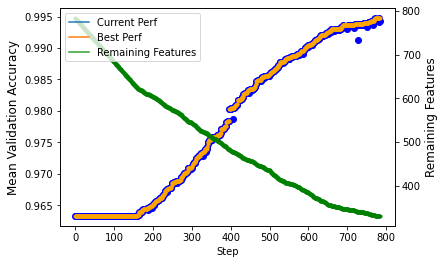

In [13]:
model = linear_model.LogisticRegression(
    penalty='none', random_state=42, solver="saga", max_iter=1e4, warm_start=True, n_jobs=-1)
pipe = pipeline.Pipeline([('scaler', scaler), ('model', model)])

pipe.fit(X_train_1d[train_idx,:], y_train[train_idx])
col_order = np.abs(pipe["model"].coef_[0]).argsort()

res = fs.dropcol_iterate(
    pipe, X_train_1d[train_idx,:], y_train[train_idx], n_spli
    ts=2, random_state=42, col_order=col_order, scoring=scoring)
fs.plot_dropcol(res["summary"])

In [14]:
dropped_idx = list(res["summary"]["col_idx"][res["summary"]["is_dropped"]])
kept_idx = res["fnl_col_idx"]

X_train_1d_drp = X_train_1d.copy()
X_train_1d_drp[:,dropped_idx] = 0
X_test_1d_drp = X_test_1d.copy()
X_test_1d_drp[:,dropped_idx] = 0

print("Selected Columns:", len(kept_idx))
print(res["perf_fnl"])
print(pipe.score(X_train_1d_drp[train_idx,:], y_train[train_idx]), pipe.score(X_test_1d_drp, y_test))
print(pipe.score(X_train_1d_drp, y_train), pipe.score(X_test_1d_drp, y_test))

Selected Columns: 331
[[0.99327481 0.99617541]]
0.992 0.9575
0.95895 0.9575


In [15]:
model = linear_model.LogisticRegression(
    penalty='none', random_state=42, solver="saga", max_iter=1e4, n_jobs=-1)

pipe = pipeline.Pipeline([('scaler', scaler), ('model', model)])
pipe.fit(X_train_1d[train_idx][:,kept_idx], y_train[train_idx])
print(pipe.score(X_train_1d[:,kept_idx], y_train), pipe.score(X_test_1d[:,kept_idx], y_test))

0.9614333333333334 0.9643


0.9611328123083163 0.9649014757034486


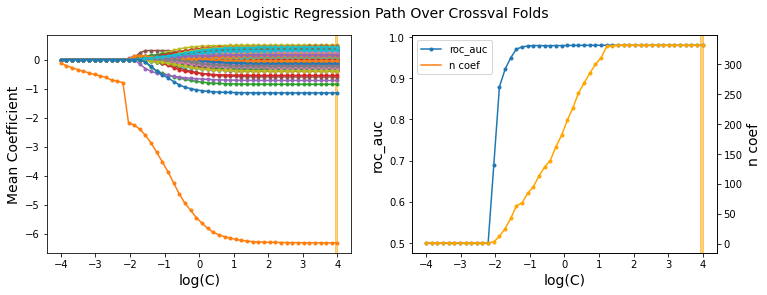

In [16]:
model = linear_model.LogisticRegressionCV(
    cv=2, Cs=50, penalty="l1", scoring=scoring, solver="saga", random_state=42, max_iter=1e4, n_jobs=-1)

pipe = pipeline.Pipeline([('scaler', scaler), ('model', model)])
pipe.fit(X_train_1d[train_idx][:,kept_idx], y_train[train_idx])
print(pipe.score(X_train_1d[:,kept_idx], y_train), pipe.score(X_test_1d[:,kept_idx], y_test))
fig, (ax1, ax2) = pr.plot_logistic_cv(pipe["model"], marker='.', figsize=[12,4], fontsize=14)

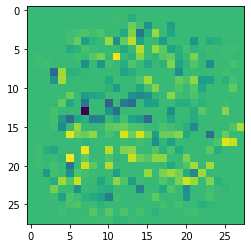

In [17]:
coefs = np.zeros(shape=X_train_1d.shape[1])
coefs[kept_idx] = pipe["model"].coef_
plt.imshow(coefs.reshape(X_train.shape[1:]))

0.9605666666666667 0.9621


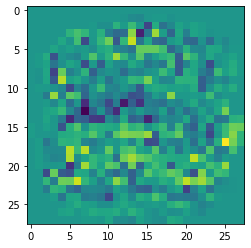

In [18]:
model = linear_model.LogisticRegression(
    penalty='none', random_state=42, solver="saga", max_iter=1e4, n_jobs=-1)

pipe = pipeline.Pipeline([('scaler', scaler), ('model', model)])
pipe.fit(X_train_1d[train_idx,:], y_train[train_idx])
print(pipe.score(X_train_1d, y_train), pipe.score(X_test_1d, y_test))
plt.imshow(pipe["model"].coef_.reshape(X_train.shape[1:]))